# Beam Size minimization using Xopt with BAXGenerator running algorithm GridOpt
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the beam size described by a simple optical model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimum beam size and its location in input-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator, BaxOptions, BayesianAlgorithmExecutionOptions
from xopt.generators.bayesian.bax.algorithms import GridMinimize
from xopt.evaluator import Evaluator

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
if torch.cuda.is_available():
# if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    use_cuda = False

# Notebook settings

In [3]:
ndim = 2 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 20 #number of random initial observations for GP model
n_samples = 20 #number of posterior samples for BAX
n_steps_sample_grid = 20 #number of steps per dimension in the sample grid-scans
n_iter = 5 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 2

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [4]:
# define test functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

beam_energy = 0.135
distance = torch.tensor(2.26).double()
q_len = torch.tensor(0.108).double()
s11 = torch.tensor(3e-6).double()
s12 = torch.tensor(1.5e-6).double()
s22 = torch.tensor(2e-6).double()

def beam_size_squared(k, d, l, s11, s12, s22):
    return (
        (1.0 + k * d * l) ** 2 * s11 + 2.0 * (1.0 + d * l * k) * d * s12 + d ** 2 * s22
    )
    
def toy_beam_size_squared_nd(x, meas_dim, noise=noise):
    
    tuning_dims = list(range(x.shape[-1]))
    tuning_dims.remove(meas_dim)
    emit = torch.sqrt(s11 * s22 - s12 ** 2)
    bss = ((1 + torch.sum(x[:,tuning_dims]**2, dim=1) )* beam_size_squared(x[:,meas_dim], distance, q_len, s11, s12, s22)).reshape(-1,1) 
    bss *= 1.e6
    if noise:
        bss *= (1 + 0.05*torch.rand_like(bss))      
    return bss

def test_func(input_dict):
    x = torch.tensor(input_dict[meas_param]).reshape(-1,1)
    for key in input_dict.keys():
        if key is not meas_param:
            x = torch.cat((x, torch.tensor(input_dict[key]).reshape(-1,1)), dim=1)
    return {'y': toy_beam_size_squared_nd(x, 0).squeeze().cpu().numpy()}

# Construct vocs

In [5]:
variables = {var_name: [-3,1] for var_name in var_names}
variables[meas_param] = [-40,40] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    objectives = {'y':"MINIMIZE"}
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
meas_param = 'x1'
domain =
 [[ -3.   1.]
 [-40.  40.]]


# Prepare generator options.
We use the generator options to package the BAX algorithm.

In [6]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.options import ModelOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions
from gpytorch.priors.torch_priors import GammaPrior

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module = MaternKernel(active_dims=tuning_dims, lengthscale_prior=GammaPrior(3.0, 6.0)) * PolynomialKernel(
    power=2, active_dims=[meas_dim]
)
scaled_covar_module = ScaleKernel(covar_module, outputscale_prior=GammaPrior(2.0, 0.15))   

# package covar module into model options for Xopt generator
model_options = ModelOptions(covar_modules=scaled_covar_module, use_low_noise_prior=True)

#Prepare Algorithm
algo = GridMinimize(domain=vocs.bounds.T,
                   n_samples=n_samples,
                   n_steps_sample_grid=n_steps_sample_grid
                   )

#package algorithm into BayesianAlgorithmExecutionOptions
bax_options = BayesianAlgorithmExecutionOptions(algo=algo)

#we will pass these options to our BaxGenerator
generator_options = BaxOptions(model=model_options, acq=bax_options) 

# Construct generator, evaluator, Xopt objects

In [7]:
#construct BAX generator
generator = BaxGenerator(vocs, generator_options)

#construct evaluator
evaluator = Evaluator(function=test_func)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
optimizer.generator.options.n_initial = n_obs_init #set number of initial observations
optimizer.generator.options.use_cuda = use_cuda #set number of initial observations

# Optimize

In [8]:
# call X.step() to generate random initial points and evaluate on test_func
optimizer.step()    

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to find the input that maximimizes the Expected Information Gain and evaluate on test_func
    optimizer.step()    
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')
    
#extract updated GP model
beam_size_model = optimizer.generator.model.models[0]

Iteration: 1 / 5
This iteration took: 22.605125904083252 seconds.

Iteration: 2 / 5
This iteration took: 16.630579948425293 seconds.

Iteration: 3 / 5
This iteration took: 9.316264867782593 seconds.

Iteration: 4 / 5
This iteration took: 8.21647047996521 seconds.

Iteration: 5 / 5
This iteration took: 12.01909065246582 seconds.



# For the 2d input space, we can plot some beam size surface samples from our current model along with our ground-truth observations.

torch.Size([6400, 2])
torch.Size([6400, 2])
torch.Size([6400, 2])


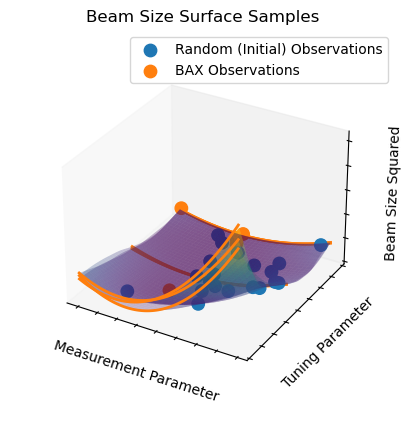

In [9]:
if ndim==2:

    fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
    fig.set_size_inches(5,5)

    for s in range(3):

        # plot first 3 beam size surface samples
        xlin, ylin = torch.arange(-3,1,0.05), torch.arange(-40,40, 1.)
        X, Y = torch.meshgrid(xlin, ylin)
        XY = torch.cat((X.reshape(-1,1), Y.reshape(-1,1)), dim=1)
        print(XY.shape)
        p = beam_size_model.posterior(XY)
        Z = p.rsample(torch.Size([n_samples]))[s].reshape(X.shape).detach()
        cmap='viridis'
        surf = ax.plot_surface(Y.cpu(), X.cpu(), Z.cpu(), cmap=cmap,
                               linewidth=0, antialiased=True, alpha=0.3, rasterized=True)

        # add orange parabolic highlights
        ax.plot(Y[0,:].cpu().numpy(), Z[0,:].cpu().numpy(), zs=X[0,0].item(), zdir='y', c='C1', lw=2, zorder=10)
        ax.plot(Y[int(len(Z[0,:])/2),:].cpu().numpy(), Z[int(len(Z[0,:])/2),:].cpu().numpy(), zs=X[int(len(Z[0,:])/2),0].item(), zdir='y', c='C1', lw=2)
        ax.plot(Y[-1,:].cpu().numpy(), Z[-1,:].cpu().numpy(), zs=X[-1,0].item(), zdir='y', c='C1', lw=2)




    # plot initial observations
    x0 = torch.tensor(optimizer.data['x0'].values)[:n_obs_init]
    x1 = torch.tensor(optimizer.data['x1'].values)[:n_obs_init]
    y = torch.tensor([item.item() for item in optimizer.data['y'].values])[:n_obs_init]
    ax.scatter(x1.flatten().cpu(), x0.flatten().cpu(), y.flatten().cpu(), marker='o', c='C0', alpha=1, s=80, label='Random (Initial) Observations', zorder=15)

    # plot bax observations
    x0 = torch.tensor(optimizer.data['x0'].values)[n_obs_init:]
    x1 = torch.tensor(optimizer.data['x1'].values)[n_obs_init:]
    y = torch.tensor([item.item() for item in optimizer.data['y'].values])[n_obs_init:]
    ax.scatter(x1.flatten().cpu(), x0.flatten().cpu(), y.flatten().cpu(), marker='o', c='C1', alpha=1, s=80, label='BAX Observations', zorder=15)

    ax.set_title('Beam Size Surface Samples')
    ax.set_ylabel('Tuning Parameter')
    ax.set_xlabel('Measurement Parameter')
    ax.set_zlabel('Beam Size Squared')

    ax.set_ylim(-3, 1)
    ax.set_zlim(0)
    
    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    ax.legend()
    ax.dist = 12

# Inspect the Acquisition Function from the last iteration and compare to most recently acquired observation 
Note that get_acquisition() is stochastic because it draws new sample paths each time and therefore produces different exe_paths and a different acquisition function than the one used in the previous iteration in Xopt. So instead of calling get_acquisition(), we manually reconstruct the acquisition function as it existed during the previous iteration.

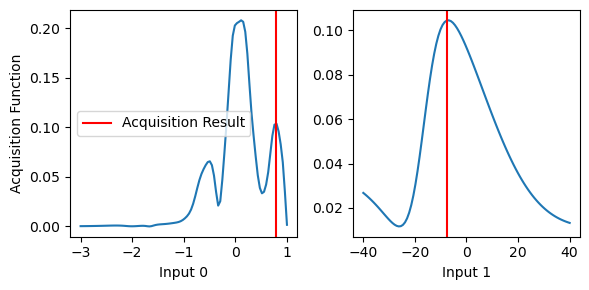

In [10]:
from xopt.generators.bayesian.bax.acquisition import ExpectedInformationGain

algo = GridMinimize(domain=vocs.bounds.T,
                   n_samples=n_samples,
                   n_steps_sample_grid=n_steps_sample_grid
                   )
acq = ExpectedInformationGain(beam_size_model, algo)
acq.xs_exe, acq.ys_exe = optimizer.generator.algo.xs_exe, optimizer.generator.algo.ys_exe
xs_exe_transformed = acq.model.input_transform(acq.xs_exe)
ys_exe_transformed = acq.model.outcome_transform(acq.ys_exe)[0]
acq.fmodels = acq.model.condition_on_observations(
    xs_exe_transformed, ys_exe_transformed
)

last_acq = np.vstack(optimizer.data.iloc[-1][list(vocs.variable_data([vocs.random_inputs()], '').keys())].values[:]).astype(float)
last_acq = torch.tensor(last_acq).reshape(1,-1)

fig, axs = plt.subplots(1, ndim)
    
fig.set_size_inches(3*(ndim), 3)

for scan_dim in range(ndim):
    X_scan = last_acq.repeat(100,1)
    ls = torch.linspace(*vocs.bounds.T[scan_dim],100)

    X_scan[:,scan_dim] = ls

    acq_scan = torch.tensor([acq(X.reshape(1,-1)) for X in X_scan]).reshape(-1)
    
    ax = axs[scan_dim]
    
    ax.plot(ls.cpu(), acq_scan.detach().cpu())
    ax.axvline(last_acq[0,scan_dim].cpu(), c='r', label='Acquisition Result')
    
    
    ax.set_xlabel('Input ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('Acquisition Function')
        ax.legend()
    
plt.tight_layout()
plt.show()